In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
X = pd.read_csv("Datasets/TCGA-PANCAN-HiSeq-801x20531/data.csv")
y = pd.read_csv("Datasets/TCGA-PANCAN-HiSeq-801x20531/labels.csv")

**KIRC**: Kidney Renal Clear Cell Carcinoma  
**PRAD**: Prostate Adenocarcinoma  
**COAD**: Chronic Obstructive Pulmonary Disease (_Lungs_)  
**LUAD**: Lung Adenocarcinoma (_also Lungs_)  
**BRCA**: Breast Cancer $Gene$ (_consist of BCRA1 & BCRA2_)

In [ ]:
df = pd.DataFrame(X, columns=breast_cancer.feature_names) 
df['target'] = breast_cancer.target
df.head()

In [7]:
df = pd.concat([X, y], axis=1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 801 entries, 0 to 800
Columns: 20534 entries, Unnamed: 0 to Class
dtypes: float64(20531), object(3)
memory usage: 125.5+ MB


In [9]:
df.sample(5)

,Unnamed: 0,gene_0,gene_1,gene_2,gene_3,gene_4,gene_5,gene_6,gene_7,gene_8,...,gene_20523,gene_20524,gene_20525,gene_20526,gene_20527,gene_20528,gene_20529,gene_20530,Unnamed: 0,Class
178,sample_178,0.000000,1.402722,1.108357,6.785655,10.285633,0.0,5.892391,0.000000,0.0,...,9.967226,3.510962,9.671364,12.007658,9.812819,9.796689,4.916477,0.0,sample_178,BRCA
549,sample_549,0.000000,4.403799,5.650767,6.237965,9.928791,0.0,8.193653,0.729357,0.0,...,10.251198,2.791001,9.827970,11.474755,9.415547,9.388187,1.860605,0.0,sample_549,LUAD
189,sample_189,0.412944,2.696305,3.288181,6.643270,9.231620,0.0,6.226936,0.000000,0.0,...,9.853738,0.412944,9.427638,12.559963,9.583453,9.143064,4.265062,0.0,sample_189,LUAD
501,sample_501,0.000000,4.177551,3.805623,8.010153,9.318511,0.0,8.005018,1.230695,0.0,...,10.272012,1.483210,8.944220,11.743408,10.784234,10.161548,3.898876,0.0,sample_501,COAD
791,sample_791,0.000000,3.080061,2.815739,6.209617,9.644469,0.0,6.351980,0.000000,0.0,...,10.205378,6.183600,10.040961,11.035335,11.030377,10.119304,7.313500,0.0,sample_791,BRCA
104,sample_104,0.000000,5.002919,4.382743,6.918971,10.219979,0.0,8.039122,1.511923,0.0,...,10.744674,5.351020,9.527549,10.808634,9.550889,9.270685,3.704540,0.0,sample_104,LUAD


In [17]:
feature_columns = df.columns.difference(['Unnamed: 0', 'Class'])
low_variance = df[feature_columns].var() < 1e-5  
filtered_features = df[feature_columns].loc[:, ~low_variance]

In [20]:
filtered_features.sample(5)

,gene_0,gene_1,gene_10,gene_100,gene_1000,gene_10000,gene_10001,gene_10002,gene_10003,gene_10004,...,gene_9990,gene_9991,gene_9992,gene_9993,gene_9994,gene_9995,gene_9996,gene_9997,gene_9998,gene_9999
565,0.0,2.479282,0.300534,10.121559,10.019021,2.303635,8.877128,8.433944,5.857254,7.351770,...,1.308885,5.612910,1.256709,3.031960,0.549127,3.222990,0.0,3.326537,0.000000,6.655562
335,0.0,4.260666,0.626205,9.957796,10.209636,1.894294,7.840847,8.307251,6.853921,7.595377,...,0.626205,3.194119,2.418946,3.277345,1.061431,4.638827,0.0,4.157674,1.666257,7.463876
143,0.0,1.904465,0.000000,10.170138,11.442244,1.524415,5.782647,7.173727,7.997072,6.920162,...,2.142609,0.000000,2.460507,2.460507,0.807932,3.427459,0.0,0.000000,0.000000,7.336694
584,0.0,4.557778,0.580628,10.368626,9.153261,2.159887,6.998399,9.363219,6.987173,8.034249,...,2.370834,6.735387,0.993566,2.796286,2.574198,4.075302,0.0,6.652538,0.000000,7.731971
21,0.0,3.529783,0.000000,10.945415,11.941081,3.565609,7.436961,7.063837,5.033247,6.651004,...,4.318375,0.000000,0.472072,1.891419,0.000000,1.111966,0.0,0.000000,0.000000,7.812312


<Axes: xlabel='Class'>

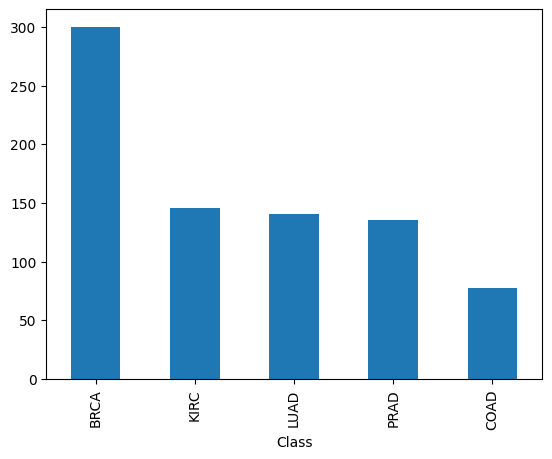

In [22]:
df['Class'].value_counts().plot(kind='bar')

In [23]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(filtered_features)

pca = PCA(n_components=100)  
X_reduced = pca.fit_transform(X_scaled)

In [29]:
# len(X_reduced[0])

100

In [40]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

X = X_reduced
y = df['Class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)
print(classification_report(y_test, y_pred))
print(accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

        BRCA       0.97      1.00      0.98        60
        COAD       1.00      1.00      1.00        16
        KIRC       1.00      1.00      1.00        30
        LUAD       1.00      0.93      0.96        28
        PRAD       1.00      1.00      1.00        27

    accuracy                           0.99       161
   macro avg       0.99      0.99      0.99       161
weighted avg       0.99      0.99      0.99       161

0.9875776397515528
